In [2]:
import numpy as np 
import gymnasium as gym
import random
import torch
import torch.nn as nn
from collections import deque
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 

In [3]:
''' Notes
>> what I understood is :
no , the actions are not selected completely at random. 
The action with higher probability is more likely to get selected but there is always some randomness involved to it to (stochastic behaviour). 
Also our nn aims to increase the probability of such actions which give maximum return. 
The multinomial function used to select action works something like this : 
        firstly it computes the cumulative distribution corresponding to our probability distributions of actions .
        Then it takes a random no. b/w 0 and 1 and then samples that action which has the cumulative prob just greater than this random no. 

>> Actor-Critic is an on-policy method, meaning the policy used to generate data (state-action pairs) is the same as the policy being improved.
   This contrasts with off-policy methods like Q-learning, which can use a different policy for exploratio

>> Advantage function helps in reducing the variance in policy gradient update. 
   It tells the actor how much better or worse the action taken is compared to the critics value estiamtes
   A(st,at) > 0 then action is good ;  A(st,at) < 0 then action is bad.

>> 1. Initialization: The actor starts with a random policy, and the critic starts with an arbitrary value function.
   2. Action Selection: Given the current state, the actor uses its policy to select an action, which is executed in the environment.

    3. Reward and Critic Update: After taking the action, the environment provides a reward. The critic then computes the TD error and updates the value function to better estimate the expected return.

    4. Policy Update: The actor uses the feedback from the critic (through the advantage function) to update its policy in the direction that improves the action selection.

    5. Repeat: This process continues, with the actor and critic continually refining their policy and value function based on the feedback loop.
>> actor_loss = -torch.log(action_prob + 1e-8) * advantage 
      the negative sign indicate that we maximize that action probability for which advantage >0 or which was worth taking!
      also maximizing log( prob) is same as maximizing prob ; Using log helps with numerical stability and improves gradient updates.
'''

' Notes\n>> what I understood is :\nno , the actions are not selected completely at random. \nThe action with higher probability is more likely to get selected but there is always some randomness involved to it to (stochastic behaviour). \nAlso our nn aims to increase the probability of such actions which give maximum return. \nThe multinomial function used to select action works something like this : \n        firstly it computes the cumulative distribution corresponding to our probability distributions of actions .\n        Then it takes a random no. b/w 0 and 1 and then samples that action which has the cumulative prob just greater than this random no. \n\n>> Actor-Critic is an on-policy method, meaning the policy used to generate data (state-action pairs) is the same as the policy being improved.\n   This contrasts with off-policy methods like Q-learning, which can use a different policy for exploratio\n\n>> Advantage function helps in reducing the variance in policy gradient updat

In [4]:
class ActorCritic(nn.Module):
    def __init__(self,state_dim,action_dim):
        super(ActorCritic,self).__init__()
        self.shared=nn.Sequential(
            nn.Linear(state_dim,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU()
        )
        
        self.actor=nn.Linear(128,action_dim)

        self.critic=nn.Linear(128,1)

    def forward(self,state):
        features = self.shared(state)
        action_probs=F.softmax(self.actor(features), dim=-1)
        state_value = self.critic(features)
        return action_probs, state_value

In [5]:
class ActorCriticAgent:
    def __init__(self,state_dim,action_dim,lr=1e-3,gamma=0.85):
        self.gamma=gamma
        self.model=ActorCritic(state_dim,action_dim)
        self.optimizer=optim.Adam(self.model.parameters(),lr=lr)

    def select_actions(self,state):
        state=torch.tensor(state,dtype=torch.float32).unsqueeze(0)
        action_probs,_=self.model(state)
        action = torch.multinomial(action_probs, 1).item() ##
       
        return action, action_probs[0, action] ##

    def update(self,state,action_prob,reward,next_state,done):
        state=torch.tensor(state,dtype=torch.float32).unsqueeze(0)

        _,state_value=self.model(state)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        _, next_state_value = self.model(next_state_tensor)

        target=reward+self.gamma*next_state_value*(1-done)
        advantage=target - state_value


        critic_loss = F.mse_loss(state_value, target) ##

        actor_loss = -torch.log(action_prob + 1e-8) * advantage

        loss=actor_loss+critic_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [6]:
env = gym.make("CartPole-v1")
state_dim=env.observation_space.shape[0]
action_dim=env.action_space.n

agent=ActorCriticAgent(state_dim,action_dim)
num_episodes=400
max_steps=200
episode_rewards=[]
for episode in range(num_episodes):
    state=env.reset()[0]
    done=False
    step_count = 0
    total_reward=0
    while(not done and step_count < max_steps):
        action,action_prob=agent.select_actions(state)
        next_state,reward,done,_,_ = env.step(action)
        agent.update(state,action_prob,reward,next_state,done)
        state=next_state
        total_reward+=reward
        step_count += 1
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")    
    episode_rewards.append(total_reward)

Episode 1: Total Reward: 11.0
Episode 2: Total Reward: 38.0
Episode 3: Total Reward: 14.0
Episode 4: Total Reward: 26.0
Episode 5: Total Reward: 17.0
Episode 6: Total Reward: 16.0
Episode 7: Total Reward: 15.0
Episode 8: Total Reward: 21.0
Episode 9: Total Reward: 10.0
Episode 10: Total Reward: 12.0
Episode 11: Total Reward: 18.0
Episode 12: Total Reward: 14.0
Episode 13: Total Reward: 9.0
Episode 14: Total Reward: 9.0
Episode 15: Total Reward: 12.0
Episode 16: Total Reward: 8.0
Episode 17: Total Reward: 13.0
Episode 18: Total Reward: 15.0
Episode 19: Total Reward: 10.0
Episode 20: Total Reward: 18.0
Episode 21: Total Reward: 10.0
Episode 22: Total Reward: 9.0
Episode 23: Total Reward: 8.0
Episode 24: Total Reward: 10.0
Episode 25: Total Reward: 10.0
Episode 26: Total Reward: 10.0
Episode 27: Total Reward: 17.0
Episode 28: Total Reward: 50.0
Episode 29: Total Reward: 11.0
Episode 30: Total Reward: 17.0
Episode 31: Total Reward: 40.0
Episode 32: Total Reward: 28.0
Episode 33: Total Rewa

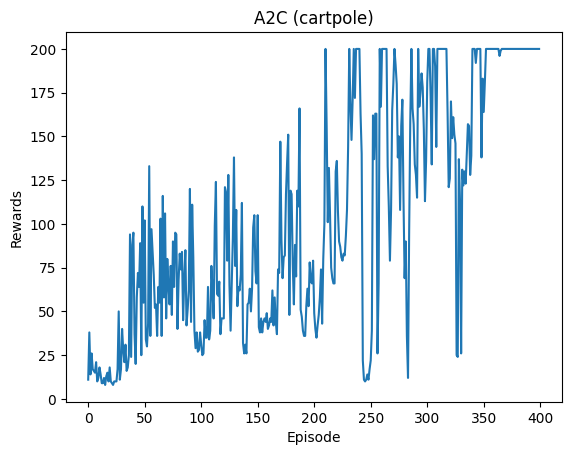

In [7]:

plt.title("A2C (cartpole)")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.plot(episode_rewards)
plt.show()

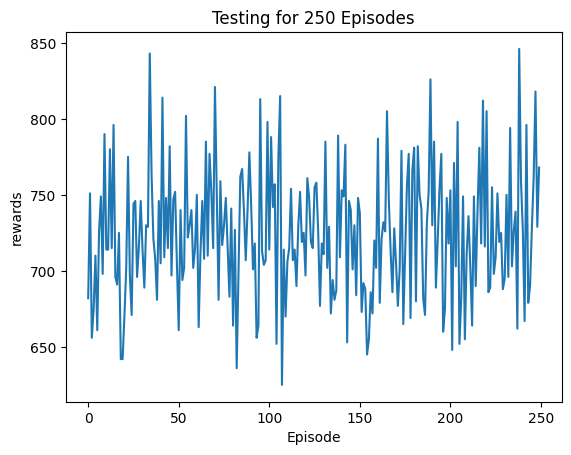

Final Score: 768.0


In [8]:

import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")
return_history = [] 
epi_num=250
for episode in range(epi_num):
    state, _ = env.reset()  
    done = False
    total_reward = 0

    while not done:  
        action,_ = agent.select_actions(state) 
        state, reward, done, _, _ = env.step(action)  
        total_reward += reward

    return_history.append(total_reward)  

env.close() 

plt.title(f"Testing for {epi_num} Episodes")
plt.xlabel("Episode")
plt.ylabel("rewards")
plt.plot(return_history)
plt.show()

print("Final Score:", total_reward)  # Print the final reward of the last episode

plt.show()

In [10]:
env = gym.make("CartPole-v1",render_mode="human")
total_reward=0
done=False
env.reset()
while not done:
        env.render()  
        action,_ = agent.select_actions(state)  
        state, reward, done, _, _ = env.step(action)  
        total_reward += reward

env.close()